# MMSE Pentagon Raw Data Extraction.
Tim Truty summer 2017:

Pulls the files from the directory of MMSE scanned documets that were classified as writing pages.
The method first finds all the contours on the page and uses a pentagon detection algorythm to find what parameters define as a drawn pentagon. 
Once pentagon is found methods are use to output the corner bitmap coordinates
Those conreres then can be analyzed... placing lines connected and other methods to get whole shape and info of pentagon.

In [134]:
# Import the required modules
from skimage.io import imread
from skimage.feature import hog
from sklearn.externals import joblib
import cv2, os, time, math, itertools, random
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Walk the path and pull MMSE scanned page
Print filename and show image

04382695 Baseline 01-10-06img-1.png


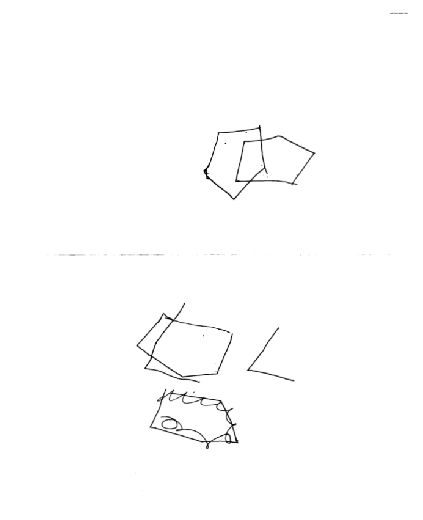

In [135]:
%matplotlib inline
path = r'E:\pent_python\training_mmse_pentagons' #home for pentagons and model file
model_path =  os.path.join(path, "models", "svm.model") # trained model
testing_path = r'E:\pent_python\mmse_data\bad' #path to pull files from
file = random.choice([x for x in os.listdir(testing_path) if os.path.isfile(os.path.join(testing_path, x))]) #random
print(file)
test_file = os.path.join(testing_path, file)

#show image
im = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.axis('off')
plt.imshow(im,cmap='gray')
plt.show()

## Find the all the contours in the image using the cv2.find contours method
http://docs.opencv.org/trunk/d3/dc0/group__imgproc__shape.html#ga17ed9f5d79ae97bd4c7cf18403e1689a

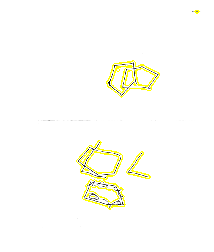

In [136]:
clone = im.copy() #clone image
color_im = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 

#preprocessing of image applying gaussianblur and thresholding OTSU
blur = cv2.GaussianBlur(clone,(5,5),0) 
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#preprocessing of image applying canny edge detection and dialtion to get all contours
edges = cv2.Canny(th3,0,255,apertureSize = 5) # Canny image 
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3)) # create the kernle
edges = cv2.dilate(edges, kernel, iterations=5)

#contour method from open CV2
im2, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) # find each contour

# show image
cv2.drawContours(color_im, contours, -1, (255,255,0), 3) #draw all contours
plt.imshow(color_im, cmap='gray')
plt.axis('off')
plt.show()

## Bound the contours in rectangles
Using Contour Features from OpenCV2
http://docs.opencv.org/trunk/dd/d49/tutorial_py_contour_features.html

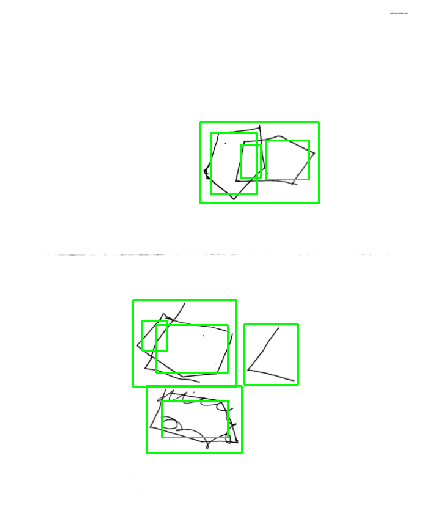

In [137]:
img = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 

for cnt in contours:
    # get the perimeter  of the contours
    hull = cv2.convexHull(cnt)
    area = cv2.contourArea(hull)
    perimeter = cv2.arcLength(hull,True)
    if perimeter != 0 and area > 200:
        x,y,w,h = cv2.boundingRect(cnt)
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

    #TO DO:
    #Combine bounding boxes for overlapping contours
#show image
fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)
plt.axis('off')
plt.show()

## Method for finding detection used on found contours
Set the threshold and place RED bounding boxes around accepted detections

Uses the HOG (Histogram Oriented Gradients) algorythm
https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog

c:\users\kinectacquisition2\appdata\local\programs\python\python35\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18.1 when using version 0.18.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
c:\users\kinectacquisition2\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


detection at 179 615 detection score: [ 0.9400596]
detection at 204 639 detection score: [ 0.10424603]
detection at 339 514 detection score: [ 0.47792757]
detection at 157 474 detection score: [ 0.95345104]
detection at 195 515 detection score: 0
detection at 172 508 detection score: [ 1.39154784]
detection at 267 183 detection score: [ 0.97464005]
detection at 333 220 detection score: 0
detection at 374 213 detection score: [ 0.02563455]
detection at 284 201 detection score: 0


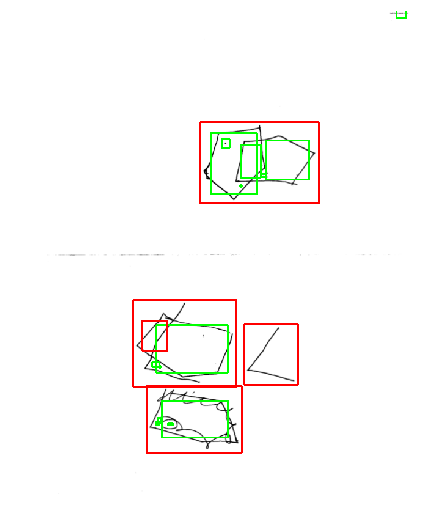

In [138]:
detection_threshold = 0.3 # change this to change accepted detection High is above 1.5... Low is 0.2 or lower

def detection(img):
    '''
    The detections methond using the HOG SVM algorithm
    '''
    clf = joblib.load(model_path) #prediciton method using SVM classifier
    kernel = np.ones((5,5),np.uint8) #kernel of 5x5 matrix
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) #reduces noise on image
    im_reshape = cv2.resize(opening, (128,128)) # standard size image to place into detection image
    fd, _ = hog(im_reshape,9, (8,8), (3,3), visualise = True, transform_sqrt=True)           
    pred = clf.predict(fd)
    #print(pred)
    #print(clf.decision_function(fd))
    if pred == 1:
        return clf.decision_function(fd)
    else:
        return 0

img = cv2.cvtColor(clone,cv2.COLOR_GRAY2BGR) 
found_dets = []

for cnt in contours:
        # get contour details
        hull = cv2.convexHull(cnt)
        area = cv2.contourArea(hull) # area of contour
        perimeter = cv2.arcLength(hull,True) #perimeter of 
        if perimeter != 0:
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            if (h*w) > 200: # minimum area of the contour bounding box
                feature = clone[y:y + h, x:x + w] #sets the focus image to within bounding box
                cd = detection(feature) #detection method on feature in bounding box
                print('detection at', x,y, 'detection score:', cd)
                if (cd > detection_threshold): #threshold for acceptance for HOG
                    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw red rect
                    found_dets.append((x, y, cd, w, h)) # add detection to list
#show image
fig=plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img)
plt.axis('off')
plt.show()


## Corner finding methods

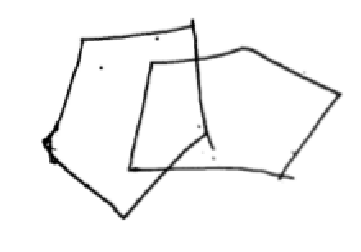

In [139]:
if found_dets != []:
    if len(found_dets) > 1:
        #max_cd = max(found_dets, key=lambda x: x[2]) #choose highest Hog det value- can cause false positive with smaller detections
        #TO DO:
        # Weight the detection based on size and detection score
        found_pent = max(found_dets, key=lambda x: x[3]*x[4]) #choose largest detecton out of the mutliple found
    else:
        found_pent = found_dets[0] #if only one detection use that one

    x,y,_,w,h = found_pent
    pentagon = clone[y:y + h, x:x + w] #pentagon is the detection

    #show image
    plt.imshow(pentagon, cmap='gray')
    plt.axis('off')
    plt.show()

## Shi Tomasi corner detection module with Open CV2
The parameters for good features to track corner detection:
goodFeaturesToTrack( Image, num corners, quality, distance)
Image, 
Max number of corners, 
Quality Level: value between 0-1, minimum quality of corner below which everyone is rejected.
Distance:  minimum euclidean distance between corners detected.
Sorts corners from stongest to weakest
http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html

Manipulation of these variables change detection:

Corners found:  13


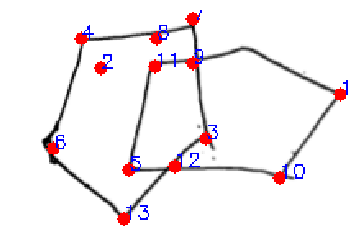

In [140]:
num_of_corners = 13
quality = 0.01
distance = 15

goodcorners = cv2.goodFeaturesToTrack(pentagon,num_of_corners, quality, distance) #shi tomasi method
goodcorners = np.int0(goodcorners) # converts to ints
print('Corners found: ', len(goodcorners))

crop = pentagon.copy()
crop = cv2.cvtColor(crop,cv2.COLOR_GRAY2BGR) #colorize image
cornernum = 1
for i in goodcorners: #show corners on the image
    cv2.circle(crop,(i[0][0],i[0][1]),4,255,-1) #draw corners
    cv2.putText(crop, str(cornernum), (i[0][0],i[0][1]), cv2.FONT_HERSHEY_SIMPLEX, .4, (0,0,255)) # number corners
    cornernum += 1
#show image
plt.imshow(crop)
plt.axis('off')
plt.show()

## Connect lines over pentagon
Places lines connecting all of the found corners and placed the lines on the image if the line cover accepted number of black pixels
Used to get overall shape of pentagon
http://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html

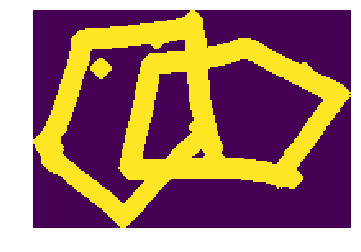

In [141]:
'''Dilage the cropped image penagon image for placing lines on'''
line_img = pentagon.copy()
line_img = cv2.cvtColor(line_img,cv2.COLOR_GRAY2BGR)

edges = cv2.Canny(line_img,0,255,apertureSize = 3) #canny image menthod
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3)) 
edges = cv2.dilate(edges, kernel, iterations=5) #dialate image
edges=edges.astype(np.uint8)

#show image
plt.imshow(edges)
plt.axis('off')
plt.show()


### Function for line methods

In [142]:
def line_points(start, end):
        "Bresenham's line algorithm"
        x0, y0 = start
        x1, y1 = end
        points_in_line = []
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        x, y = x0, y0
        sx = -1 if x0 > x1 else 1
        sy = -1 if y0 > y1 else 1
        if dx > dy:
            err = dx / 2.0
            while x != x1:
                points_in_line.append((x, y))
                err -= dy
                if err < 0:
                    y += sy
                    err += dx
                x += sx
        else:
            err = dy / 2.0
            while y != y1:
                points_in_line.append((x, y))
                err -= dx
                if err < 0:
                    x += sx
                    err += dy
                y += sy
        points_in_line.append((x, y))
        return points_in_line

### Connect all corners with line
Using the itertools combination method iterate over every combination of the corners and connect those lines.

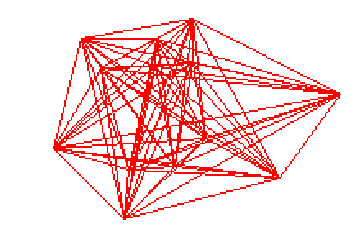

In [143]:

lines = itertools.combinations(goodcorners,2) # create all possible lines
blank_img = np.ones_like(line_img)*255 # white image to draw line markings on
for line in lines:
    bin_line = np.zeros_like(edges) # create a matrix to draw the line in
    start, end = line # grab endpoints
    points = line_points(start[0], end[0]) #use Bresenham's line algorithm for points on line
    cv2.line(blank_img, tuple(start[0]), tuple(end[0]), color=255, thickness=1) # draw line
#show image
plt.imshow(blank_img)
plt.axis('off')
plt.show()

### Check lines over the the original image
Check each corner combination line over the original dialated image and onle return the lines that meet the threshold of coverage over line


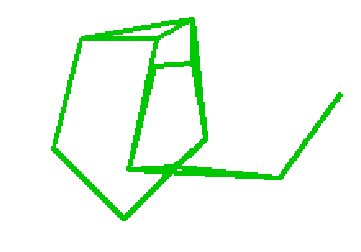

In [144]:
cover_threshold = 0.95

lines = itertools.combinations(goodcorners,2) # create all possible lines
blank_img = np.ones_like(line_img)*255 # white image to draw line markings on
for line in lines:
    bin_line = np.zeros_like(edges) # create a matrix to draw the line in
    start, end = line # grab endpoints
    points = line_points(start[0], end[0]) # Bresenham's line algorithm
    cv2.line(bin_line, tuple(start[0]), tuple(end[0]), color=255, thickness=1) # draw line for compare
    conj = (edges/255 + bin_line/255) # create agreement image
    n_agree = np.sum(conj==2) # add all of the good cover points
    n_wrong = np.sum(conj==1) #can use to get bad lines
    if n_agree/(len(points)) > cover_threshold: # high agreements vs disagreements
        cv2.line(blank_img, tuple(start[0]), tuple(end[0]), color=[0,200,0], thickness=2) #draw good line
#show image
plt.imshow(blank_img)
plt.axis('off')
plt.show()

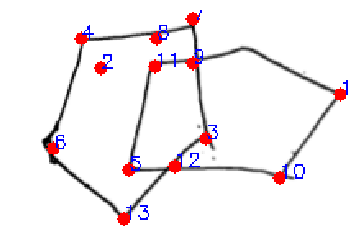

In [145]:
#show corner image again
plt.imshow(crop)
plt.axis('off')
plt.show()